In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Verificacion del entorno

def verify_environment():
    print("Verificando entorno...")

    # Verificar Python
    print(f"Python version: {sys.version}")

    # Verificar PyTorch y CUDA
    print(f"PyTorch version: {torch.__version__}")
    print(f"CUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"CUDA device: {torch.cuda.get_device_name(0)}")

    # Verificar estructura del proyecto
    required_files = ['models.py', 'utils.py', 'conf/config.yaml']
    for file in required_files:
         if not os.path.exists(file):
             raise FileNotFoundError(f"Missing required file: {file}")

    # Verificar dataset
    if not os.path.exists('Butterfly-dataset2'):
        raise FileNotFoundError("Dataset directory not found")

    print("\nEntorno verificado correctamente ✓")

verify_environment()

Verificando entorno...
Python version: 3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]
PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA device: Tesla T4

Entorno verificado correctamente ✓


In [ ]:
# === CELDA DE CONFIGURACIÓN WANDB ===
import wandb

WANDB_API_KEY = "2348384a098c46310b56fea3a0ecc9c25d4ccd90"
def setup_wandb_online():
    """Configura Weights & Biases en modo online"""
    print("=== Configuración de Weights & Biases Online ===")

    # Configurar API key
    os.environ["WANDB_API_KEY"] = WANDB_API_KEY

    # Intentar login
    try:
        wandb.login()

        # Verificar configuración con una prueba
        with wandb.init(
            project="butterfly-experiment2",
            name="test-connection",
            tags=["test"],
        ) as run:
            wandb.log({"connection_test": 1.0})

        print("\n✓ Conexión exitosa con wandb")
        print("✓ Login verificado")
        print("✓ Logging probado correctamente")
        print("\nWeights & Biases está configurado correctamente en modo online")

    except Exception as e:
        print(f"\n❌ Error al configurar wandb: {e}")
        print("Por favor, verifica tu API key y conexión a internet")
        raise e

# Ejecutar configuración
setup_wandb_online()

=== Configuración de Weights & Biases Online ===


connection_test,▁
connection_test,1



✓ Conexión exitosa con wandb
✓ Login verificado
✓ Logging probado correctamente

Weights & Biases está configurado correctamente en modo online


<ipython-input-65-f0e11a5175b0>:239: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path=None)


Configuración: {'model': {'encoder_channels': [64, 128, 256], 'decoder_channels': [128, 64, 3]}, 'training': {'epochs': 30, 'batch_size': 64, 'learning_rate': 0.001, 'noise_prob': 0.1}, 'dataset': {'data_dir': '/content/drive/MyDrive/Proyecto3-IA/Butterfly-dataset2', 'img_size': [128, 128]}}


<ipython-input-65-f0e11a5175b0>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.cat([torch.tensor(labels) for _, labels in dataloader])


epoch,▁▃▅▆█
train_loss,█▂▂▁▁
val_loss,█▃▂▁▁
epoch,5
train_loss,0.00893
val_loss,0.00966


Epoch [1/30], Train Loss: 1.5482, Valid Loss: 0.0458
Epoch [2/30], Train Loss: 0.6492, Valid Loss: 0.0266
Epoch [3/30], Train Loss: 0.4539, Valid Loss: 0.0220
Epoch [4/30], Train Loss: 0.3856, Valid Loss: 0.0197
Epoch [5/30], Train Loss: 0.3399, Valid Loss: 0.0169
Epoch [6/30], Train Loss: 0.2982, Valid Loss: 0.0136
Epoch [7/30], Train Loss: 0.2408, Valid Loss: 0.0123
Epoch [8/30], Train Loss: 0.2221, Valid Loss: 0.0121
Epoch [9/30], Train Loss: 0.2139, Valid Loss: 0.0109
Epoch [10/30], Train Loss: 0.1982, Valid Loss: 0.0101
Epoch [11/30], Train Loss: 0.1836, Valid Loss: 0.0111
Epoch [12/30], Train Loss: 0.1771, Valid Loss: 0.0090
Epoch [13/30], Train Loss: 0.2034, Valid Loss: 0.0093
Epoch [14/30], Train Loss: 0.1634, Valid Loss: 0.0085
Epoch [15/30], Train Loss: 0.1575, Valid Loss: 0.0082
Epoch [16/30], Train Loss: 0.1523, Valid Loss: 0.0081
Epoch [17/30], Train Loss: 0.1478, Valid Loss: 0.0080
Epoch [18/30], Train Loss: 0.1627, Valid Loss: 0.0083
Epoch [19/30], Train Loss: 0.1467, Va

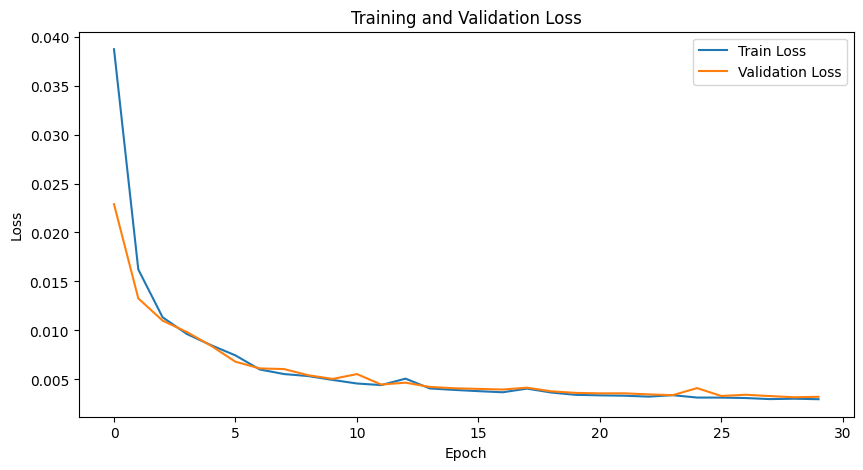

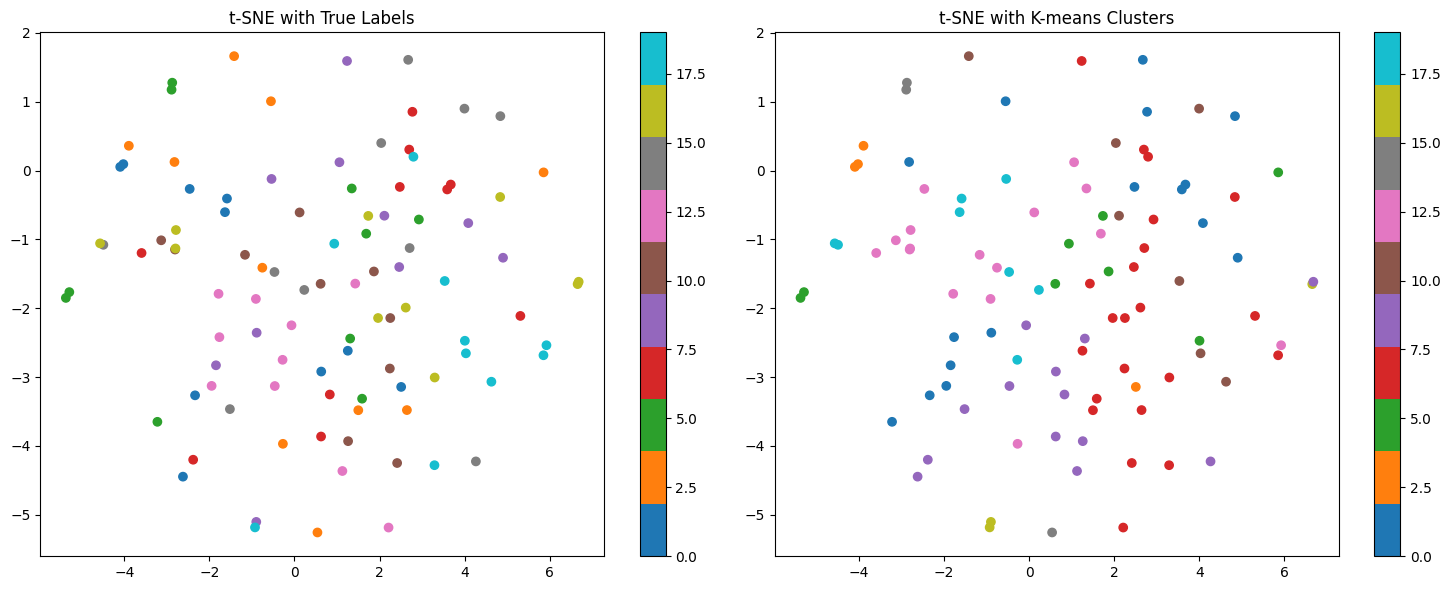

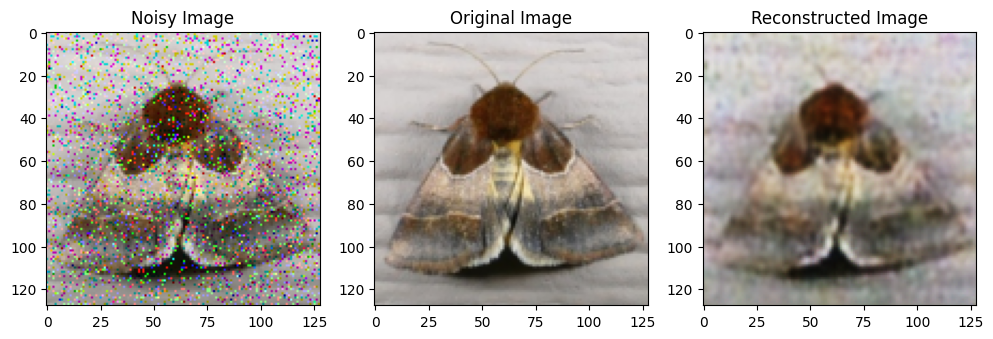

In [ ]:
# Se importan las bibliotecas
import os
import torch
import hydra
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from omegaconf import DictConfig
from omegaconf import OmegaConf
import random
import wandb  # Para la integración con WandB

# %%%%%%%%%%  Función para agregar ruido Salt and Pepper %%%%%%%%%%%%%
def salt_and_pepper_noise(images, prob=0.1):
    """
    Agrega ruido de tipo Salt and Pepper a las imágenes.
    :param images: Tensor de imágenes.
    :param prob: Probabilidad de aplicar ruido.
    """
    noisy_images = images.clone()
    for img in noisy_images:
        num_pixels = img.numel()
        noise = torch.rand(num_pixels).to(img.device)
        salt = (noise < prob / 2).reshape(img.shape)
        pepper = (noise > 1 - prob / 2).reshape(img.shape)
        img[salt] = 1.0  # Sal
        img[pepper] = 0.0  # Pimienta
    return noisy_images

# %%%%%%%%%%  Dataset personalizado para imágenes ruidosas %%%%%%%%%%%%%
class DenoisingDataset(Dataset):
    """
    Dataset para manejar imagenes limpias y con ruido.
    """
    def __init__(self, dataloader, noise_prob=0.1):
        self.clean_images = torch.cat([imgs for imgs, _ in dataloader], dim=0)
        self.labels = torch.cat([torch.tensor(labels) for _, labels in dataloader])
        self.noise_prob = noise_prob

    def __len__(self):
        return len(self.clean_images)

    def __getitem__(self, idx):
        clean_img = self.clean_images[idx]
        noisy_img = salt_and_pepper_noise(clean_img.unsqueeze(0), self.noise_prob).squeeze(0)
        return (noisy_img, clean_img), self.labels[idx]

# %%%%%%%%%%  Clase del modelo: Denoising Autoencoder %%%%%%%%%%%%%
class DenoisingAutoencoder(torch.nn.Module):
    """
    Red neuronal autoencoder para eliminar ruido de imágenes.
    """
    def __init__(self):
        super().__init__()
        enc = [64, 128, 256]  # Canales del codificador
        dec = [128, 64, 3]    # Canales del decodificador

        # Codificador
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(3, enc[0], kernel_size=3, stride=2, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(enc[0], enc[1], kernel_size=3, stride=2, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(enc[1], enc[2], kernel_size=3, stride=2, padding=1),
            torch.nn.ReLU()
        )

        # Decodificador
        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(enc[2], dec[0], kernel_size=3, stride=2, padding=1, output_padding=1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(dec[0], dec[1], kernel_size=3, stride=2, padding=1, output_padding=1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(dec[1], dec[2], kernel_size=3, stride=2, padding=1, output_padding=1),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        latent = self.encoder(x)  # Extracción de características latentes
        reconstructed = self.decoder(latent)  # Reconstrucción de la imagen
        return reconstructed, latent

# %%%%%%%%%%  Función de entrenamiento del modelo %%%%%%%%%%%%%
def train_model(model, train_loader, valid_loader, epochs, noise_prob):
    """
    Entrena el modelo con los datos ruidosos y calcula las pérdidas.
    :param model: Modelo a entrenar.
    :param train_loader: Dataloader para entrenamiento.
    :param valid_loader: Dataloader para validación.
    :param epochs: Número de épocas de entrenamiento.
    """
    wandb.init(project="denoising-autoencoder", config={
        "epochs": epochs,
        "noise_prob": noise_prob,
        "learning_rate": 0.001
    })
    config = wandb.config

    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
    criterion = torch.nn.MSELoss()

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for (noisy_imgs, clean_imgs), _ in train_loader:
            noisy_imgs, clean_imgs = noisy_imgs.to("cuda"), clean_imgs.to("cuda")
            reconstructed, _ = model(noisy_imgs)

            loss = criterion(reconstructed, clean_imgs)  # Comparación entre reconstruida y limpia
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        # Validación
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for (noisy_imgs, clean_imgs), _ in valid_loader:
                noisy_imgs, clean_imgs = noisy_imgs.to("cuda"), clean_imgs.to("cuda")
                reconstructed, _ = model(noisy_imgs)
                val_loss += criterion(reconstructed, clean_imgs).item()

        val_losses.append(val_loss / len(valid_loader))

        # Registro en WandB
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss / len(train_loader),
            "val_loss": val_loss / len(valid_loader)
        })

        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Valid Loss: {val_loss:.4f}")

    # Graficar pérdidas
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

# %%%%%%%%%%  Función para mostrar imágenes ruidosas y reconstruidas %%%%%%%%%%%%%
def show_images(noisy_imgs, clean_imgs, reconstructed_imgs, idx=0):
    """
    Muestra imágenes originales, ruidosas y reconstruidas lado a lado.
    :param noisy_imgs: Imágenes ruidosas.
    :param clean_imgs: Imágenes originales.
    :param reconstructed_imgs: Imágenes reconstruidas.
    :param idx: Índice de la imagen a mostrar.
    """
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(noisy_imgs[idx].permute(1, 2, 0).cpu().numpy())
    axes[0].set_title("Noisy Image")
    axes[1].imshow(clean_imgs[idx].permute(1, 2, 0).cpu().numpy())
    axes[1].set_title("Original Image")
    axes[2].imshow(reconstructed_imgs[idx].detach().permute(1, 2, 0).cpu().numpy())
    axes[2].set_title("Reconstructed Image")
    plt.show()

# %%%%%%%%%%  Visualización de latentes usando t-SNE y K-means %%%%%%%%%%%%%
def visualize_latents(model, dataloader):
    """
    Visualiza los latentes del modelo usando t-SNE y clustering con K-means.
    :param model: Modelo entrenado.
    :param dataloader: Dataloader de validación.
    """
    model.eval()
    latents = []
    true_labels = []

    with torch.no_grad():
        for (noisy_imgs, _), labels in dataloader:
            noisy_imgs = noisy_imgs.to("cuda")
            _, latent = model(noisy_imgs)
            latents.append(latent.view(latent.size(0), -1).cpu())
            true_labels.extend(labels.cpu().numpy())

    latents = torch.cat(latents, dim=0).numpy()
    true_labels = np.array(true_labels)

    # t-SNE para reducción de dimensionalidad
    tsne = TSNE(n_components=2, random_state=42)
    latent_2d = tsne.fit_transform(latents)

    # K-means clustering
    n_clusters = len(np.unique(true_labels))
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(latents)

    # Visualización
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    scatter1 = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=true_labels, cmap='tab10')
    plt.colorbar(scatter1)
    plt.title('t-SNE with True Labels')

    plt.subplot(1, 2, 2)
    scatter2 = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=cluster_labels, cmap='tab10')
    plt.colorbar(scatter2)
    plt.title('t-SNE with K-means Clusters')

    plt.tight_layout()
    plt.show()

# %%%%%%%%%%  Configuración Hydra %%%%%%%%%%%%%
hydra_cfg = OmegaConf.create({
    "model": {
        # Arquitectura del modelo: canales para el codificador y decodificador
        "encoder_channels": [64, 128, 256],
        "decoder_channels": [128, 64, 3]
    },
    "training": {
        # Hiperparámetros de entrenamiento
        "epochs": 30,  # Num epochs
        "batch_size": 64,  # Tamaño del batch
        "learning_rate": 0.001,  # Tasa de aprendizaje
        "noise_prob": 0.1  # Probabilidad de ruido
    },
    "dataset": {
        # Configuración del dataset
        "data_dir": "/content/drive/MyDrive/Proyecto3-IA/Butterfly-dataset2",  # Ruta del dataset
        "img_size": [128, 128]  # Tamanio de las imágenes
    }
})


# %%%%%%%%%%  Ejecución principal con Hydra %%%%%%%%%%%%%
@hydra.main(config_path=None)
def main(cfg: DictConfig):
    """
    Entrena el modelo usando la configuración especificada en Hydra.
    """
    print("Configuración:", cfg)

    transform = transforms.Compose([
        transforms.Resize(cfg.dataset.img_size),
        transforms.ToTensor()
    ])

    # Cargar datos de entrenamiento y validación
    train_data = datasets.ImageFolder(os.path.join(cfg.dataset.data_dir, "train"), transform=transform)
    valid_data = datasets.ImageFolder(os.path.join(cfg.dataset.data_dir, "valid"), transform=transform)

    train_loader = DataLoader(train_data, batch_size=cfg.training.batch_size, shuffle=True)
    valid_loader = DataLoader(valid_data, batch_size=cfg.training.batch_size, shuffle=False)

    train_noisy_dataset = DenoisingDataset(train_loader, noise_prob=cfg.training.noise_prob)
    valid_noisy_dataset = DenoisingDataset(valid_loader, noise_prob=cfg.training.noise_prob)

    train_noisy_loader = DataLoader(train_noisy_dataset, batch_size=cfg.training.batch_size, shuffle=True)
    valid_noisy_loader = DataLoader(valid_noisy_dataset, batch_size=cfg.training.batch_size, shuffle=False)

    # Inicializar modelo
    dae_model = DenoisingAutoencoder().to("cuda")

    # Entrenar modelo
    train_model(dae_model, train_noisy_loader, valid_noisy_loader, cfg.training.epochs, cfg.training.noise_prob)
    visualize_latents(dae_model, valid_noisy_loader)

    # Mostrar imágenes reconstruidas
    dae_model.eval()
    with torch.no_grad():
        for (noisy_imgs, clean_imgs), _ in valid_noisy_loader:
            noisy_imgs, clean_imgs = noisy_imgs.to("cuda"), clean_imgs.to("cuda")
            reconstructed_imgs, _ = dae_model(noisy_imgs)
            show_images(noisy_imgs, clean_imgs, reconstructed_imgs, idx=0)
            break  # Se muestra un batch

# Iniciar
main(hydra_cfg)
